# Overview

The goal of this exercise is to create a fully worked out F2 edition of the text. F2 refers to Standard Text Analytic Data Model (STADM):

> A normalized set of tables including DOC, TOKEN, and TERM tables. Produced by the tokenization of F1 data. Other tables and columns may be added, such as sentiment and other labels to the DOC table. May be stored in a relational database or stand-alone files (such as CSV). The text form level is similar to so-called "tidy text format' from the R community.	

# Recap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
BODY_START = 341
BODY_END = 21964
CHAP_PAT = r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = '2701-0.txt'
    
# Text to lines
lines = open(src_file, 'r', encoding='utf-8').readlines()
lines = lines[BODY_START - 1 : BODY_END + 1]
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

# Lines to Chapters
mask = df.line_str.str.match(CHAP_PAT)
df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
df.chap_id = df.chap_id.ffill().astype('int')
chap_ids = df.chap_id.unique().tolist()
df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
chaps = df.groupby('chap_num')\
    .apply(lambda x: ''.join(x.line_str))\
    .to_frame()\
    .rename(columns={0:'chap_str'})

# Chapters to Paragraphs
paras = chaps.chap_str.str.split(PARA_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = ['chap_num', 'para_num']
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]

# Paragraphs to Sentences
sents = paras.para_str.str.split(SENT_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})
sents.index.names = ['chap_num', 'para_num', 'sent_num']

# Sentences to Tokens
tokens = sents.sent_str.str.split(TOKEN_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'token_str'})
tokens.index.names = ['chap_num', 'para_num', 'sent_num', 'token_num']

# Clean up
del(df, lines, chaps, paras, sents, mask)

# Tag punction
tokens['punc'] = tokens.token_str.str.match(r'^\W*$').astype('int')

In [3]:
tokens

token_str  punc
chap_num para_num sent_num token_num                   
0        0        0        0            ETYMOLOGY     0
                  1        0                          1
                           1                    .     1
                           2                          1
                  2        0                          1
         1        0        0                          1
                           1                    (     1
                           2             Supplied     0
                           3                          1
                           4                   by     0
                           5                          1
                           6                    a     0
                           7                          1
                           8                 Late     0
                           9                          1
                           10         Consumptive     0
                           11                         1
                           12               Usher     0
                           13                         1
                           14                  to     0
                           15                         1
                           16                   a     0
                           17                         1
                           18             Grammar     0
                           19                         1
                           20              School     0
                  1        0                          1
                           1                    .     1
                           2                          1
                  2        0                          1
...                                           ...   ...
136      3        22       13                  ,      1
                           14                that     0
                           15                         1
                           16                  in     0
                           17                         1
                           18                 her     0
                           19                         1
                           20           retracing     0
                           21                         1
                           22              search     0
                           23                         1
                           24               after     0
                           25                         1
                           26                 her     0
                           27                         1
                           28             missing     0
                           29                         1
                           30            children     0
                           31                  ,      1
                           32                only     0
                           33                         1
                           34               found     0
                           35                         1
                           36             another     0
                           37                         1
                           38              orphan     0
                  23       0                          1
                           1                    .     1
                           2                          1
                  24       0                          1

[502534 rows x 2 columns]

# Explore

## Now get paragraphs and chapters back

In [4]:
paras2 = tokens.groupby(['chap_num','para_num']).token_str.apply(lambda x: ''.join(x))\
    .to_frame()\
    .rename(columns={'token_str':'para_str'})

In [5]:
chaps2 = paras2.groupby(['chap_num']).para_str.apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'para_str':'chap_str'})

## Define function to recreate OHCO chunks

In [6]:
def gather_chunks(df, div_names, doc_str = 'token_str', sep=''):
    chunks = df.groupby(div_names)[doc_str].apply(lambda x: x.str.cat(sep=sep))
    chunks.columns = ['doc_content']
    return chunks.to_frame()

In [7]:
# chaps = gather_chunks(tokens, ['chap_num'], sep=' ')
# paras = gather_chunks(tokens, ['chap_num', 'para_num'], sep='')
# sents = gather_chunks(tokens, ['chap_num', 'para_num', 'sent_num'])

## View non-puncuation token counts

In [8]:
token_counts = tokens[tokens.punc == 0].token_str.str.lower().value_counts()

In [9]:
token_counts.head(2|5)

the     14430
of       6609
and      6430
a        4737
to       4625
in       4173
that     3085
Name: token_str, dtype: int64

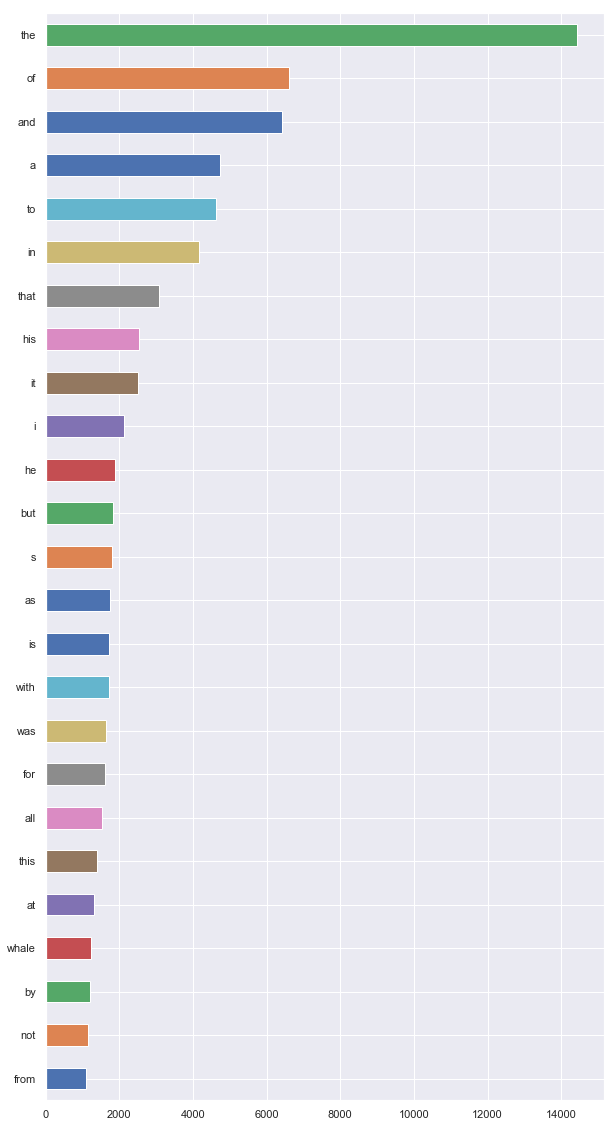

In [10]:
token_counts.head(25).sort_values().plot(kind='barh', figsize=(10,20))

## Save Tokens dataframe to file

In [11]:
tokens.to_csv('moby-tokens.csv')

# Create Vocabulary table

In [12]:
tokens.loc[tokens.punc == 0, 'term_str'] = tokens.token_str.str.lower()

In [13]:
vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'term_str', 'term_str':'n'})
vocab = vocab.sort_values('term_str').reset_index()
vocab.index.name = 'term_id'
vocab = vocab.drop('index', 1)

In [14]:
vocab

,term_str,n
term_id,,
0,(_,69
1,_,128
2,—_,80
3,(_,10
4,", (_",1
5,", _",40
6,",—_",1
7,000,20
8,1,4


## Show top 25 terms

In [15]:
vocab.sort_values('n', ascending=False).head(25)

,term_str,n
term_id,,
15057,the,14430
10248,of,6609
699,and,6430
214,a,4737
15287,to,4625
7651,in,4173
15055,that,3085
7184,his,2530
8188,it,2521


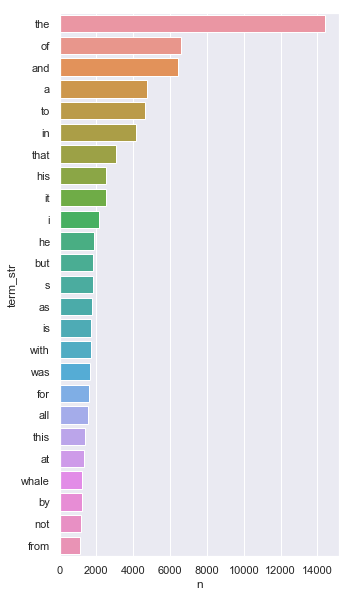

In [16]:
top_terms = vocab.sort_values('n', ascending=False).head(25)
plt.figure(figsize=(5,10))
sns.barplot(data=top_terms, y='term_str', x='n', orient='h')
plt.show()

## Add term ID to tokens

In [17]:
tokens['term_id'] = tokens['term_str'].map(vocab.reset_index().set_index('term_str').term_id).fillna(-1).astype('int')
# tokens.term_id = tokens.term_id.astype('int')

In [18]:
tokens[tokens.punc == 0].sort_values('term_id').sample(10)

,,,,token_str,punc,term_str,term_id
chap_num,para_num,sent_num,token_num,,,,
51,1,10,2,Helena,0,helena,7070
36,36,8,6,not,0,not,10090
105,11,4,26,whale,0,whale,16729
77,6,2,56,feet,0,feet,5653
16,48,0,46,me,0,me,9341
32,22,8,20,baleen,0,baleen,1232
71,8,50,28,measureless,0,measureless,9361
104,6,12,60,of,0,of,10248
54,11,4,14,gaining,0,gaining,6274


## Define convenience functions for vocabulary

In [19]:
def get_term_id(term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(term_id):
    return vocab.loc[term_id].term_str

In [20]:
get_term_id('ahab')

522

In [21]:
get_term_str(16729)

'whale'

In [22]:
vocab.loc[16729]

term_str    whale
n            1228
Name: 16729, dtype: object

## Create pure tokens tables

In [23]:
tokens2 = tokens[tokens.term_id >= 0].drop('term_str', axis=1)

## Dispersion Plots, etc.

In [24]:
kahuna = pd.get_dummies(tokens.reset_index()['term_str']).T

In [25]:
kahuna.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,502524,502525,502526,502527,502528,502529,502530,502531,502532,502533
demanding,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jingle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
toadstools,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
shines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
delivery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
female,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
christmas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
englishmen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


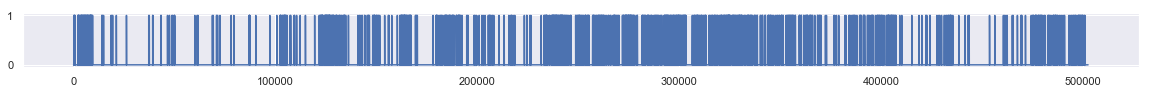

In [26]:
kahuna.loc['whale'].plot(figsize=(20,1))

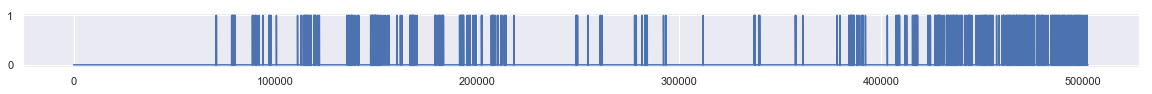

In [27]:
kahuna.loc['ahab'].plot(figsize=(20,1))

In [28]:
terms = ['stubb', 'ahab','whale', 'starbuck', 'queequeg', 'ishmael', 'white', 'sea', 'ship', 'church', 'death']

In [29]:
viz_df = kahuna.loc[terms].T\
  .stack()\
  .to_frame()\
  .reset_index()\
  .rename(columns={'level_0': 't', 'level_1':'term_str', 0:'n'})

In [30]:
viz_df[viz_df.n > 0].sample(5)

,t,term_str,n
3172484,288407,sea,1
3204786,291344,whale,1
1868564,169869,ishmael,1
1311454,119223,ahab,1
3457583,314325,ship,1


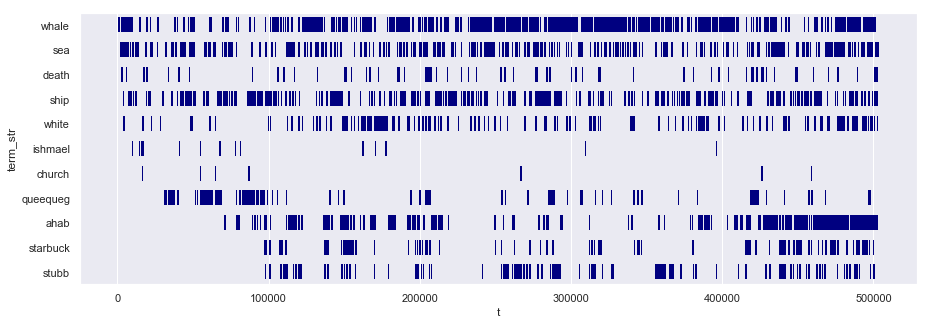

In [31]:
plt.figure(figsize=(15,5))
sp = sns.stripplot(y='term_str', x='t', data=viz_df[viz_df.n == 1],
 orient='h', marker="$|$", color='navy', size=15, jitter=0)
plt.show()

# Experiment -- Can We Detect Stopwords by Entropy?

In [32]:
TDM = tokens[tokens.term_id >= 0].groupby(['chap_num','term_str']).term_str.count().to_frame().unstack().fillna(0.00001).T

In [33]:
TDM = TDM.apply(lambda x: x / x.sum(), 1)

In [34]:
TDH = TDM.apply(lambda x: -(x * np.log2(x))).sum(1).to_frame().rename(columns={0:'H'})

In [35]:
TDH = TDH.reset_index().drop('level_0', 1)

In [36]:
TDH.H.idxmax()

2540

In [37]:
TDH.loc[2540]

term_str    chapter
H           6.82126
Name: 2540, dtype: object

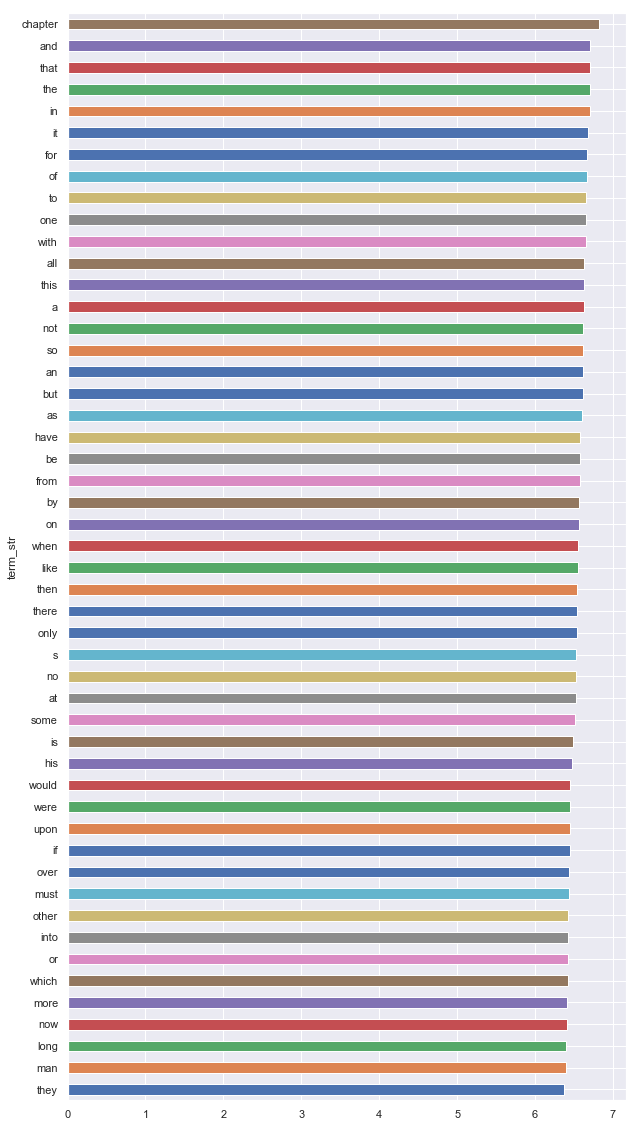

In [38]:
TDH.sort_values('H', ascending=False)\
    .reset_index().set_index('term_str').H\
    .head(50).sort_values().plot(kind='barh', figsize=(10,20))

In [39]:
## Add entropy to Vocabulary

In [40]:
vocab = vocab.merge(TDH, on='term_str', copy=False)

In [41]:
# vocab = vocab.drop(['H_x','H_y'], 1)

In [42]:
vocab.sort_values('H', ascending=False)

,term_str,n,H
2540,chapter,173,6.821259
699,and,6430,6.710230
15055,that,3085,6.708981
15057,the,14430,6.703840
7651,in,4173,6.702097
8188,it,2521,6.682740
5987,for,1617,6.672563
10248,of,6609,6.666222
15287,to,4625,6.658245
10305,one,921,6.648833


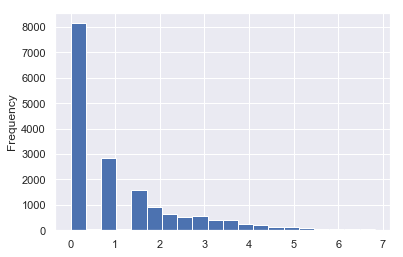

In [43]:
vocab.H.plot.hist(bins=20)

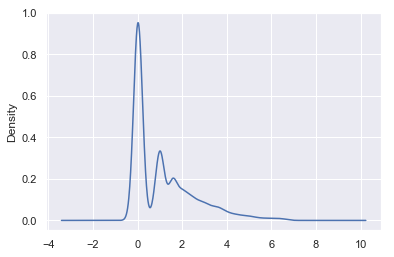

In [44]:
vocab.H.plot.kde()

In [45]:
vocab.H.describe()

count    17159.000000
mean         1.143861
std          1.398616
min          0.000414
25%          0.024519
50%          1.012177
75%          1.926835
max          6.821259
Name: H, dtype: float64

In [46]:
vocab[vocab.H > vocab.H.quantile(.95)].sort_values('H', ascending=False)

,term_str,n,H
2540,chapter,173,6.821259
699,and,6430,6.710230
15055,that,3085,6.708981
15057,the,14430,6.703840
7651,in,4173,6.702097
8188,it,2521,6.682740
5987,for,1617,6.672563
10248,of,6609,6.666222
15287,to,4625,6.658245
10305,one,921,6.648833
